# DP2031电源控制与上电电流记录Jupyter Notebook

本Jupyter Notebook旨在演示如何控制DP2031可编程直流电源，实现多通道按序上电，并实时记录上电过程中的各通道电流。

**注意：** 在运行此Notebook之前，请确保已安装 `pyvisa`, `numpy`, `matplotlib` 库。您还需要确保DP2031电源已通过USB或LAN连接到您的计算机，并且您知道其VISA地址。

---

## 1. 导入必要的库和辅助函数



In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import pyvisa

# 辅助函数：获取项目根目录 (从main.py复制)
def get_base_path():
    if getattr(sys, 'frozen', False):
        return os.path.dirname(sys.executable)
    else:
        return os.path.dirname(os.path.abspath(__file__))

print("所有库和辅助函数已导入。")
print("指向的虚拟环境文件夹:",sys.executable)

所有库和辅助函数已导入。
指向的虚拟环境文件夹: d:\SVN\usr\weihaoyu\Rigel\cp_test\cp_test\Scripts\python.exe


## 2. 连接DP2031电源

使用PyVISA连接到DP2031电源。请将 `dp2031_visa_address` 替换为您的实际VISA地址。

---



In [2]:
rm = pyvisa.ResourceManager()
print(rm.list_resources())

('USB0::0x1AB1::0xA4A8::DP2A265201089::INSTR', 'TCPIP0::172.18.26.76::inst0::INSTR', 'TCPIP0::K-34465A-05164.local::hislip0::INSTR', 'TCPIP0::K-34465A-05164.local::inst0::INSTR', 'TCPIP0::172.18.26.44::inst0::INSTR', 'TCPIP0::172.18.26.142::inst0::INSTR', 'TCPIP0::172.18.26.92::inst0::INSTR', 'TCPIP0::172.18.26.108::inst0::INSTR', 'ASRL1::INSTR')


In [3]:

dp2031 = None

dp2031_visa_address = "USB0::0x1AB1::0xA4A8::DP2A265201089::INSTR"  # 替换为您的DP2031的VISA地址

try:
    dp2031 = rm.open_resource(dp2031_visa_address)
    print(f"成功连接到DP2031: {dp2031.query('*IDN?')}")
    dp2031.write("*RST") # 重置电源到已知状态
    time.sleep(0.1)
except Exception as e:
    print(f"连接DP2031失败: {e}")



成功连接到DP2031: Rigol Technologies,DP2031,DP2A265201089,00.01.01.00.22



## 3. 配置通道上电顺序和参数

定义每个通道的目标电压、限流和上电顺序。

---



In [4]:
if dp2031:
    # 定义通道上电顺序及参数
    # 顺序为 (通道号, 目标电压V, 限流A)
    power_on_sequence = [
        (1, 2.3, 0.5),   # 通道1: 2.3V, 0.5A 限流
        (2, 1.6, 0.5),   # 通道2: 1.6V, 0.5A 限流
        (3, 6, 1)    # 通道3: -6V, 1A 限流
    ]

    print("通道上电顺序和参数已定义。")
else:
    print("DP2031未连接，无法定义通道参数。")



通道上电顺序和参数已定义。


## 4. 按序上电并记录电流

按照设定的顺序依次打开每个通道，并在上电过程中实时记录各通道的电流。每个通道上电后会有一小段稳定时间进行采样。

---



In [5]:
if dp2031 and 'power_on_sequence' in locals():
    # --- 修改点 1: 初始化电压数据字典 ---
    current_data = {f'CH{ch}': [] for ch, _, _ in power_on_sequence}
    voltage_data = {f'CH{ch}': [] for ch, _, _ in power_on_sequence} # 新增
    timestamps = []

    sampling_interval = 0.1 
    settling_time = 2     

    print("开始按序上电并记录电流和电压...")
    start_time = time.time()

    # 初始化关闭
    for ch, _, _ in power_on_sequence:
        dp2031.write(f'OUTP CH{ch},OFF')
        
    time.sleep(settling_time) 

    for ch, voltage, current_limit in power_on_sequence:
        print(f"正在配置通道 {ch}: {voltage}V, {current_limit}A")
        dp2031.write(f'APPL CH{ch},{voltage},{current_limit}')
        dp2031.write(f'OUTP CH{ch},ON')
        time.sleep(settling_time) 

        # 记录数据
        for _ in range(int(settling_time / sampling_interval) + 1):
            # --- 修改点 2: 增加电压查询 ---
            # 为了准确，对每个通道分别查询电压和电流
            is_ch1 = 1 in [p[0] for p in power_on_sequence]
            is_ch2 = 2 in [p[0] for p in power_on_sequence]
            is_ch3 = 3 in [p[0] for p in power_on_sequence]

            if is_ch1:
                voltage_data['CH1'].append(float(dp2031.query('MEAS:VOLT? CH1')))
                current_data['CH1'].append(float(dp2031.query('MEAS:CURR? CH1')))
            if is_ch2:
                voltage_data['CH2'].append(float(dp2031.query('MEAS:VOLT? CH2')))
                current_data['CH2'].append(float(dp2031.query('MEAS:CURR? CH2')))
            if is_ch3:
                voltage_data['CH3'].append(float(dp2031.query('MEAS:VOLT? CH3')))
                current_data['CH3'].append(float(dp2031.query('MEAS:CURR? CH3')))
            
            timestamps.append(time.time() - start_time)
            time.sleep(sampling_interval)
        print(f"通道 {ch} 上电完成并采集数据。")
    
    print("所有通道上电及数据采集完成。")
else:
    print("DP2031未连接...")

开始按序上电并记录电流和电压...
正在配置通道 1: 2.3V, 0.5A
通道 1 上电完成并采集数据。
正在配置通道 2: 1.6V, 0.5A
通道 2 上电完成并采集数据。
正在配置通道 3: 6V, 1A
通道 3 上电完成并采集数据。
所有通道上电及数据采集完成。


## 5. 电流值范围比较

比较记录到的上电电流值是否在预设的正常范围内。

---



In [6]:
# --- 新增：创建结果文件夹与获取文件名 ---
results_dir = "results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)  # 如果文件夹不存在则创建

file_suffix = input("请输入本次测试的文件名后缀 (例如 test_01): ")
if not file_suffix:
    file_suffix = "default"

# 定义包含文件夹路径的完整文件名
log_path = os.path.join(results_dir, f"dp2031_log_{file_suffix}.txt")
png_path = os.path.join(results_dir, f"dp2031_plot_{file_suffix}.png")

print(f"日志将保存至: {log_path}")
print(f"图片将保存至: {png_path}")
# ------------------------------------


if 'current_data' in locals() and current_data:
    # 定义每个通道的正常电流范围 (最小值, 最大值) A
    # 假设这些范围是根据预期负载和电源特性设定的
    expected_current_ranges = {
        1: (0.15, 0.2), # CH1 正常电流范围 0.15A 到 0.2A
        2: (0, 0.001), # CH2 正常电流范围 0.0A 到 0.001A
        3: (0.25, 0.35)  # CH3 正常电流范围 0.25A 到 0.35A
    }

    # 准备日志内容（既包含电流数据，也包含范围比较结果）
    from datetime import datetime
    log_lines = []
    log_lines.append("================ DP2031 Power On Current Log ================\n")
    log_lines.append(f"Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    # 如果有时间戳数据，则先以 CSV 形式保存每个时间点的各通道电流
    if 'timestamps' in locals() and timestamps:
        channel_names = sorted(current_data.keys())
        log_lines.append("\n[Data Samples]\n")
        # 构建表头: Time, CH1_Volt, CH1_Curr, CH2_Volt, CH2_Curr...
        header = "Time(s)"
        for ch in channel_names:
            header += f",{ch}_Volt(V),{ch}_Curr(A)"
        log_lines.append(header + "\n")

        for idx, t in enumerate(timestamps):
            row_str = f"{t:.3f}"
            for ch in channel_names:
                # 获取电压和电流，防止索引越界
                if idx < len(current_data[ch]):
                    v_val = voltage_data[ch][idx]
                    c_val = current_data[ch][idx]
                    row_str += f",{v_val:.4f},{c_val:.6f}"
                else:
                    row_str += ",,"
            log_lines.append(row_str + "\n")

    print("\n--- 电压电流范围检查 ---")
    log_lines.append("\n[Range Check]\n")
    power_on_status = True

    for i, (ch_num, _, _) in enumerate(power_on_sequence):
        ch_name = f'CH{ch_num}'
        if ch_name in current_data and current_data[ch_name]:
            # 获取该通道上电后的稳定电流值（这里简化为最后几个点的平均值或最大值）
            # 为了简化，我们取上电后一段时间内的最大电流作为判断依据
            # 实际应用中可能需要更复杂的判断逻辑，例如排除瞬态尖峰
            measured_currents = np.array(current_data[ch_name][-5:]) # 取最后5个点进行判断
            peak_current = np.max(measured_currents)

            min_expected, max_expected = expected_current_ranges.get(ch_num, (0, 9999)) # 如果未定义范围则默认为宽松范围

            line_header = f"通道 {ch_num}:"
            print(line_header)
            log_lines.append(line_header + "\n")

            line_peak = f"  测量到峰值电流: {peak_current:.4f} A"
            line_range = f"  预期电流范围: {min_expected:.4f} A - {max_expected:.4f} A"
            print(line_peak)
            print(line_range)
            log_lines.append(line_peak + "\n")
            log_lines.append(line_range + "\n")

            if min_expected <= peak_current <= max_expected:
                status_line = "  -> 状态: 正常"
                print(status_line)
                log_lines.append(status_line + "\n")
            else:
                status_line = "  -> 状态: 异常 (超出预期范围)"
                print(status_line)
                log_lines.append(status_line + "\n")
                power_on_status = False
        else:
            no_data_line = f"通道 {ch_num}: 没有采集到电流数据，无法判断。"
            print(no_data_line)
            log_lines.append(no_data_line + "\n")
            power_on_status = False

    if power_on_status:
        conclusion_line = "\n结论: 所有通道上电电流均在正常范围内。"
        print(conclusion_line)
        log_lines.append(conclusion_line + "\n")
    else:
        conclusion_line = "\n结论: 检测到通道上电电流异常。请检查。"
        print(conclusion_line)
        log_lines.append(conclusion_line + "\n")

    # 将日志写入文本文件（追加方式），文件名可根据需要修改
    try:
        with open(log_path, "a", encoding="utf-8") as f:
            f.writelines(log_lines)
        print(f"电流数据和范围比较结果已追加保存到 {log_path}")
    except Exception as e:
        print(f"保存日志到 {log_path} 时发生错误: {e}")

else:
    print("没有电流数据进行比较。请先运行上电并记录电流步骤。")



日志将保存至: results\dp2031_log_test_01.txt
图片将保存至: results\dp2031_plot_test_01.png

--- 电压电流范围检查 ---
通道 1:
  测量到峰值电流: 0.0000 A
  预期电流范围: 0.1500 A - 0.2000 A
  -> 状态: 异常 (超出预期范围)
通道 2:
  测量到峰值电流: 0.0000 A
  预期电流范围: 0.0000 A - 0.0010 A
  -> 状态: 正常
通道 3:
  测量到峰值电流: 0.0016 A
  预期电流范围: 0.2500 A - 0.3500 A
  -> 状态: 异常 (超出预期范围)

结论: 检测到通道上电电流异常。请检查。
电流数据和范围比较结果已追加保存到 results\dp2031_log_test_01.txt


## 6. 数据可视化

绘制记录到的各通道电流随时间变化的曲线。

---



电压电流变化图已保存为 results\dp2031_plot_test_01.png


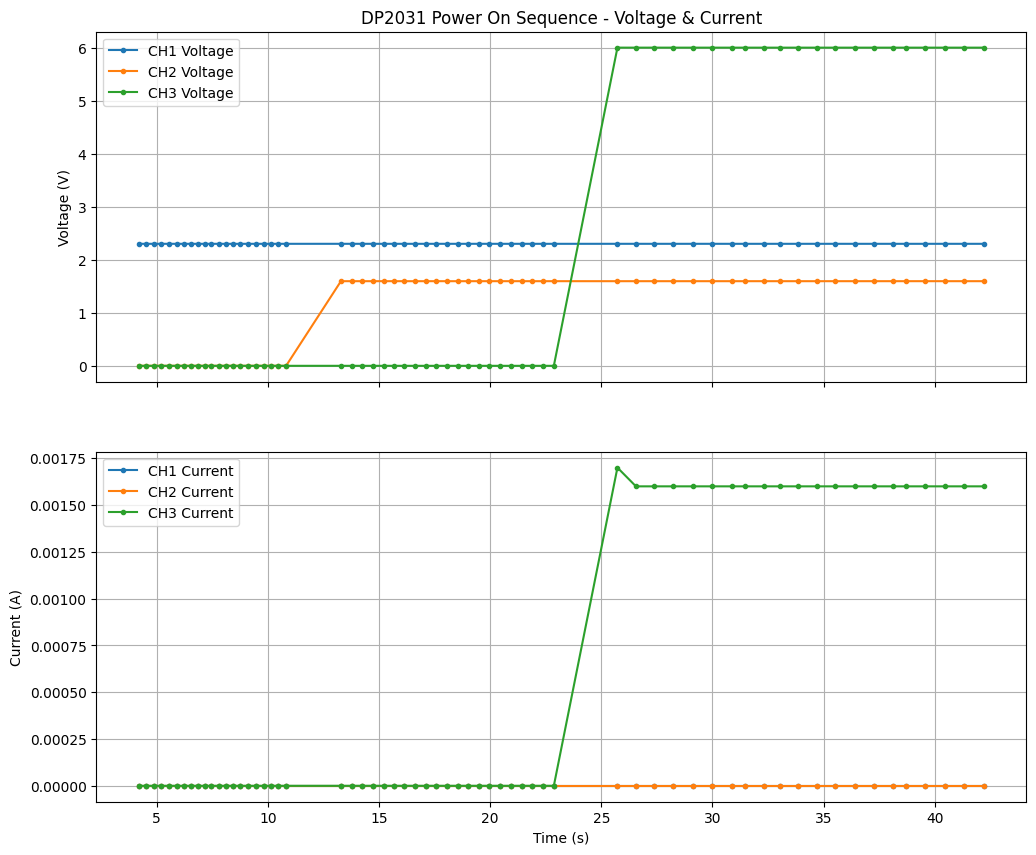

In [7]:
if 'timestamps' in locals() and 'current_data' in locals() and timestamps:
    # --- 修改点: 创建双子图 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # 绘制电压 (上图)
    for ch_name, volts in voltage_data.items():
        if volts:
            ax1.plot(timestamps, volts, marker='.', linestyle='-', label=f'{ch_name} Voltage')
    ax1.set_ylabel("Voltage (V)")
    ax1.set_title("DP2031 Power On Sequence - Voltage & Current")
    ax1.grid(True)
    ax1.legend()

    # 绘制电流 (下图)
    for ch_name, currents in current_data.items():
        if currents:
            ax2.plot(timestamps, currents, marker='.', linestyle='-', label=f'{ch_name} Current')
    ax2.set_ylabel("Current (A)")
    ax2.set_xlabel("Time (s)")
    ax2.grid(True)
    ax2.legend()

    # 保存图片 (使用之前定义的 png_path)
    if 'png_path' in locals():
        plt.savefig(png_path)
        print(f"电压电流变化图已保存为 {png_path}")
    else:
        plt.savefig("dp2031_power_on_combined.png")
        
    plt.show()
else:
    print("没有数据进行可视化。")



## 7. 断开仪器连接，清理资源

确保在完成测试后安全断开与DP2031电源的连接。

---



In [8]:
# --- 修改后的第 7 步：分别询问关闭输出和断开连接 ---

if dp2031:
    # === 询问 1: 是否关闭输出 ===
    ask_output = input("是否关闭所有通道输出？(y/n, 默认为y): ").strip().lower()
    
    if ask_output != 'n':  # 默认为 y (执行关闭)
        try:
            # 关闭所有通道输出, 关闭顺序与上电顺序相反
            if 'power_on_sequence' in locals():
                for ch, _, _ in reversed(power_on_sequence):
                    dp2031.write(f'OUTP CH{ch},OFF')
            print("所有通道输出已关闭。")
        except Exception as e:
            print(f"关闭通道时发生错误: {e}")
    else:
        print("已跳过。通道仍保持输出状态。")

    # === 询问 2: 是否断开连接 ===
    ask_close = input("是否断开与 DP2031 的 VISA 连接？(y/n, 默认为y): ").strip().lower()
    
    if ask_close != 'n':  # 默认为 y (执行断开)
        try:
            dp2031.close()
            dp2031 = None  # 将对象置空，防止后续误操作
            print("DP2031 连接已断开。")
        except Exception as e:
            print(f"断开连接时发生错误: {e}")
    else:
        print("连接保持中。您可以重新运行第 4 步进行下一次测试。")

else:
    print("DP2031 未连接，无法执行操作。")
print("Notebook执行完毕。")

所有通道输出已关闭。
连接保持中。您可以重新运行第 4 步进行下一次测试。
Notebook执行完毕。
